# pytiva Tiny Tutorial
Last updated 5 February 2023

In [1]:
import os
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

# these two lines will be unnecessary if pytiva is installed as a python package
import sys
sys.path.append("/home/tj/PycharmProjects/pytiva")

import pytiva

# working directory
wd = r'/home/tj/PycharmProjects/pytiva/data'

### Extracting from an Excel file
Data exports from electronic anesthesia records may be in a variety of file formats, but Microsoft Excel is a fairly common one.

pytiva has utilities to extract these as a batch process and set them aside in comma-separated values formats.

In [2]:
sheets = {
    'cases': {
        'SHEET_LABEL': 'Base',
        'CSV_FILENAME': 'cases'
    },
    'events': {
        'SHEET_LABEL': 'Events',
        'CSV_FILENAME': 'case_events'
    },
    'medications': {
        'SHEET_LABEL': 'Medications',
        'CSV_FILENAME': 'case_medications'
    }
}

filepaths_out = pytiva.utils.dump_csv_from_excel(
    os.path.join(wd, 'OBCapacity_Output_20221130.xlsx'),
    wd,
    sheets,
    csv_prefix='202302050900-')
filepaths_out

['/home/tj/PycharmProjects/pytiva/data/202302050900-cases.csv',
 '/home/tj/PycharmProjects/pytiva/data/202302050900-case_events.csv',
 '/home/tj/PycharmProjects/pytiva/data/202302050900-case_medications.csv']

### Loading CSV files into a pytiva AnesthesiaStudy object
An AnesthesiaStudy object holds multiple DataSet objects and has methods for interacting with them. Column names, which were left alone in the Excel-->CSV step, can be updated at this step, and extra columns can be trimmed out.

(Each type of standardized anesthesia DataSet within pytiva expects particular columns in order to reliably produce functionality. For example, they all require a 'case_id' column, which is a unique identifier for the given admission in order to have the case data, medication data, and intra-operative event data all interact.)

In [3]:
csv_dict = {
    'ds_cases': {
        'FILEPATH': os.path.join(wd, '202302050900-cases.csv'),
        'COLUMN_MAP': {
            'AN_52_ENC_CSN_ID': 'case_id',
            'AN_START_DATETIME': 'anesthesia_start',
            'AN_STOP_DATETIME': 'anesthesia_end',
            'AN_PROC_NAME': 'procedure',
            'DepartmentName': 'location'
        },
        'LIMIT_COLUMNS_BY_MAP': True
    },

    'ds_case_meds': {
        'FILEPATH': os.path.join(wd, '202302050900-case_medications.csv'),
        'COLUMN_MAP': {
            'AN_52_ENC_CSN_ID': 'case_id',
            'MED_DISPLAY_NAME': 'med_name',
            'TAKEN_TIME': 'med_datetime',
            'UNIT_NAME': 'med_unit',
            'ROUTE_NAME': 'med_route',
            'DOSAGE': 'med_amount'
        },
        'LIMIT_COLUMNS_BY_MAP': True
    },
    'ds_case_events': {
        'FILEPATH': os.path.join(wd, '202302050900-case_events.csv'),
        'COLUMN_MAP': {
            'AN_52_ENC_CSN_ID': 'case_id',
            'EVENT_NAME': 'event_label',
            'EVENT_TIME': 'event_datetime'
        },
        'LIMIT_COLUMNS_BY_MAP': True
    }
}

datasets = pytiva.anesthesia.datasets_from_csv_data(csv_dict)
study = pytiva.anesthesia.AnesthesiaStudy(**datasets)
study

## AnesthesiaStudy object ##
ds_cases['anesthesia_start'] range: 2021-02-01 00:34:00 to 2022-11-01 21:23:00
ds_cases (23448 rows)
ds_case_events (406297 rows)
ds_case_meds (229690 rows)

### Setting up study parameters
An AnesthesiaStudy object has methods to limit the included cases by dates and procedures, as well as to generate anesthesia activity based on medication administration and intra-operative events. These can be called directly, or in a batch as a configuration dictionary.

In [4]:
STUDY_CONFIG = {
    'CASE_LIMITS': {
        'ANESTHESIA_START_RANGE': ('2021-10-01', '2021-10-31'),
        'PROCEDURES': [
            'CESAREAN SECTION REPEAT (N/A Abdomen)',
            'CS',
            'C Section',
            'CESAREAN SECTION PRIMARY 1919 (Bilateral )',
            'CESAREAN SECTION PRIMARY 1919',
            'CESAREAN SECTION REPEAT WITH BILATERAL TUBAL LIGATION (Bilateral )',
            'Cesarean Delivery',
            'CESAREAN SECTION UNDEFINED (N/A )',
            'CESAREAN SECTION REPEAT',
            'CESAREAN SECTION REPEAT (N/A )',
            'REPEAT LOW TRANSVERSE CESAREAN SECTION (N/A )',
            'BLOOD PATCH',
            'CESAREAN SECTION REPEAT (Bilateral )',
            'CESAREAN SECTION (N/A )',
            'D&E (N/A Uterus)',
            'REPEAT CESAREAN SECTION (N/A )',
            'CERVICAL CERCLAGE 1917',
            'CERVICAL CERCLAGE 1917 (N/A )',
            'CESAREAN SECTION REPEAT. (N/A )',
            'EXTERNAL CEPHALIC VERSION',
            'TUBAL LIGATION/CLIP (WITH CESAREAN SECTION) 2959 (N/A )',
            'CESAREAN SECTION PRIMARY 1919 (N/A )',
            'CESAREAN SECTION PRIMARY 1919 (N/A Abdomen)',
            'LABOR EPIDURAL/ANALGESIA',
            'DILATATION AND CURETTAGE POST PARTUM (N/A )',
            'REPAIR VAGINAL TEAR (N/A )',
            'CESAREAN SECTION REPEAT LOW TRANSVERSE (N/A )',
            'D&C under regional',
            'ECV',
            'INDUCTION',
            'PPBTL'
        ]
    },
    'ACTIVITIES': {
        'MEDICATION_ACTIVITY_OFFSET_BEFORE': pd.to_timedelta(2, unit='minute'),
        'MEDICATION_ACTIVITY_OFFSET_AFTER': pd.to_timedelta(2, unit='minute'),
        'EVENT_ACTIVITY_DEFINITIONS': [
            {
                'LABEL': 'regional procedure',
                'EVENT_START': 'Link Anesthesia Device',
                'EVENT_END': 'Block dosed',
                'MAX_DURATION_QUANTILE': 0.9,
                'MAX_DURATION_FACTOR': 2
            },
            
            {
                'LABEL': 'operating room case',
                'EVENT_START': 'Patient in Room',
                'EVENT_END': 'Anesthesia Stop',
                'MAX_DURATION_QUANTILE': 0.95,
                'MAX_DURATION_FACTOR': 2
            }
        ]
    }
}

study.process_study_config(STUDY_CONFIG)
study

## AnesthesiaStudy object ##
ds_cases['anesthesia_start'] range: 2021-10-01 03:25:00 to 2021-10-30 20:58:00
ds_cases (448 rows)
ds_case_events (6341 rows)
ds_case_meds (2785 rows)
ds_activity: "medication" (2785 entries), "regional procedure" (112 entries), "operating room case" (82 entries)

### Concurrent activity and visualization
AnesthesiaStudy objects also provide methods for unduplicating the anesthesia activity contained in the various DataSet objects. By default, these unduplicate at the level of a case_id, meaning they unduplicate the data such that the maximum activity per case id at one time is one. Effectively, each patient is reduced to at most one activity at each moment in time.

The AnesthesiaStudy.unduplicate_concurrency() method exposes this functionality most simply. Under the hood, it first unduplicates and then determines concurrency (total unduplicated activity) for each moment in time. The strata used for unduplication can be overwritten by providing a different collection to strata (default strata=['case_id']), and the resolution of the concurrent activity can be set by passing a parseable string to resolution for creating a TimeDelta object (default resolution='1min').

In [5]:
cc_ts = study.unduplicate_concurrency(strata=['case_id'], resolution='15min')

100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 160.92it/s]


100%|████████████████████████████████████████████| 6/6 [00:00<00:00, 121.71it/s]


100%|██████████████████████████████████████████| 14/14 [00:00<00:00, 182.34it/s]


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 136.52it/s]


100%|███████████████████████████████████████| 2195/2195 [01:08<00:00, 32.16it/s]


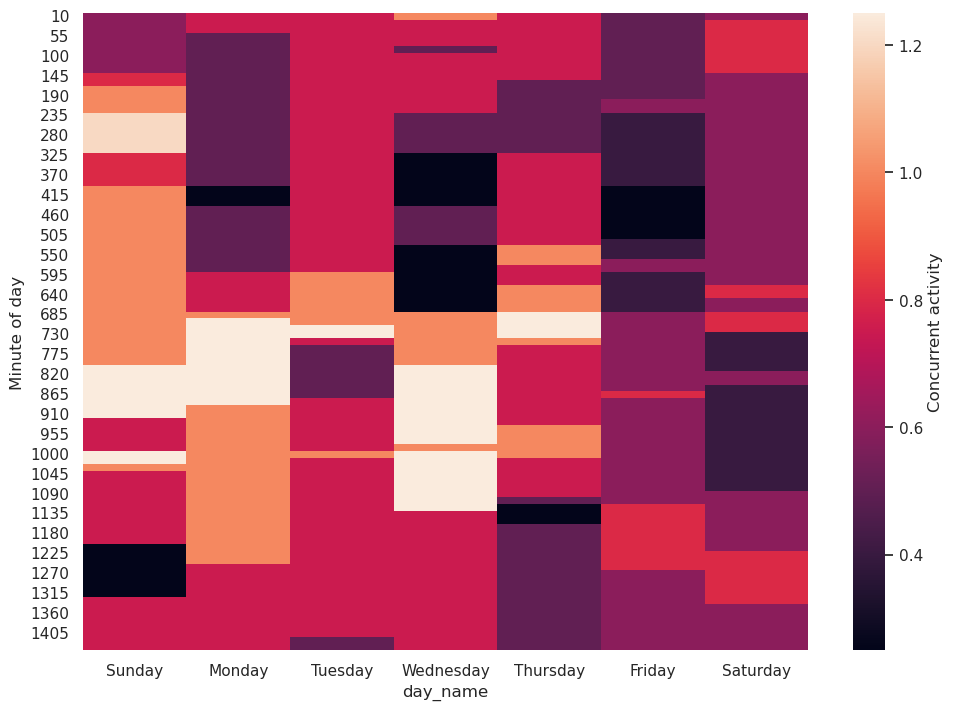

In [11]:
#cc_activity = study.ds_activity.concurrency_ts(resolution='15min')
cc_activity_wa = pytiva.activity.utils.concurrent_weekly_activity(cc_ts)
graph = sn.heatmap(cc_activity_wa, robust=True,
                  cbar_kws={
                      'label': 'Concurrent activity',
                      #'ticks': [0.0, 0.5, 1.0, 1.5, 2.0, 2.5]
                           })
plt.ylabel('Minute of day')
sn.set(rc={'figure.figsize':(11.7,8.27)})
plt.show()